In [1]:
from keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D
from keras.layers import Concatenate, Activation
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

Using TensorFlow backend.


In [2]:
def side_branch(x, factor):
    x = Conv2D(1, (1, 1), activation=None, padding='same')(x)

    kernel_size = (2*factor, 2*factor)
    x = Conv2DTranspose(1, kernel_size, strides=factor, padding='same', use_bias=False, activation=None)(x)

    return x

In [3]:
def hed():
    # Input
    img_input = Input(shape=(None, None, 3), name='input')

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    b1= side_branch(x, 1) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block1_pool')(x) # 240 240 64

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    b2= side_branch(x, 2) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block2_pool')(x) # 120 120 128

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    b3= side_branch(x, 4) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block3_pool')(x) # 60 60 256

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    b4= side_branch(x, 8) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block4_pool')(x) # 30 30 512

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x) # 30 30 512
    b5= side_branch(x, 16) # 480 480 1

    # fuse
    fuse = Concatenate(axis=-1)([b1, b2, b3, b4, b5])
    fuse = Conv2D(1, (1,1), padding='same', use_bias=False, activation=None)(fuse) # 480 480 1

    # outputs
    o1    = Activation('sigmoid', name='o1')(b1)
    o2    = Activation('sigmoid', name='o2')(b2)
    o3    = Activation('sigmoid', name='o3')(b3)
    o4    = Activation('sigmoid', name='o4')(b4)
    o5    = Activation('sigmoid', name='o5')(b5)
    ofuse = Activation('sigmoid', name='ofuse')(fuse)


    # model
    model = Model(inputs=[img_input], outputs=[o1, o2, o3, o4, o5, ofuse])
    filepath = 'hed_weights_6outputs_120epochs_loss0018.h5'
    load_weights_from_hdf5_group_by_name(model, filepath)

    model.compile(loss={'o1': cross_entropy_balanced,
                        'o2': cross_entropy_balanced,
                        'o3': cross_entropy_balanced,
                        'o4': cross_entropy_balanced,
                        'o5': cross_entropy_balanced,
                        'ofuse': cross_entropy_balanced,
                        },
                  metrics={'ofuse': ofuse_pixel_error},
                  optimizer='adam')
    
#     model = Model(inputs=[img_input], outputs=[ofuse, o1, o2, o3, o4, o5])
#     filepath = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
#     load_weights_from_hdf5_group_by_name(model, filepath)
#     model.load_weights("hed_weights_trainableFalse_1000epochs.h5")

#     model.compile(loss={'ofuse': cross_entropy_balanced,},
#                   metrics={'ofuse': ofuse_pixel_error},
#                   optimizer='adam')

    return model

In [4]:
def cross_entropy_balanced(y_true, y_pred):

    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, Keras expects probabilities.
    # transform y_pred back to logits
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.log(y_pred/ (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)

    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)

    # Equation [2]
    beta = count_neg / (count_neg + count_pos)

    # Equation [2] divide by 1 - beta
    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)

    # Multiply by 1 - beta
    cost = tf.reduce_mean(cost * (1 - beta))

    # check if image has no edge pixels return 0 else return complete error function
    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)

In [5]:
def ofuse_pixel_error(y_true, y_pred):
    pred = tf.cast(tf.greater(y_pred, 0.5), tf.int32, name='predictions')
    error = tf.cast(tf.not_equal(pred, tf.cast(y_true, tf.int32)), tf.float32)
    return tf.reduce_mean(error, name='pixel_error')


def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
    x: An object to be converted (numpy array, list, tensors).
    dtype: The destination type.
    # Returns
    A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x


def load_weights_from_hdf5_group_by_name(model, filepath):
    ''' Name-based weight loading '''

    import h5py

    f = h5py.File(filepath, mode='r')

    flattened_layers = model.layers
    layer_names = [n.decode('utf8') for n in f.attrs['layer_names']]

    # Reverse index of layer name to list of layers with name.
    index = {}
    for layer in flattened_layers:
        if layer.name:
            index.setdefault(layer.name, []).append(layer)

    # we batch weight value assignments in a single backend call
    # which provides a speedup in TensorFlow.
    weight_value_tuples = []
    for k, name in enumerate(layer_names):
        g = f[name]
        weight_names = [n.decode('utf8') for n in g.attrs['weight_names']]
        weight_values = [g[weight_name] for weight_name in weight_names]

        for layer in index.get(name, []):
            symbolic_weights = layer.weights
            if len(weight_values) != len(symbolic_weights):
                raise Exception('Layer #' + str(k) +
                                ' (named "' + layer.name +
                                '") expects ' +
                                str(len(symbolic_weights)) +
                                ' weight(s), but the saved weights' +
                                ' have ' + str(len(weight_values)) +
                                ' element(s).')
            # set values
            for i in range(len(weight_values)):
                weight_value_tuples.append((symbolic_weights[i], weight_values[i]))
                K.batch_set_value(weight_value_tuples)

In [6]:
model = hed()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [7]:
imgs_val = np.load("./datasets/val.npy")
labels_val = np.load("./datasets/val_label.npy")
imgs_val = imgs_val.astype('float32')
labels_val = labels_val.astype('float32')
imgs_val /= 255
labels_val /= 255
# mean = imgs_train.mean(axis=0)
# imgs_train -= mean
# labels_val /= 255
# imgs_mask_train[imgs_mask_train > 0.5] = 1
# imgs_mask_train[imgs_mask_train <= 0.5] = 0

In [8]:
data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True)

train_datagen = ImageDataGenerator(**data_gen_args, rescale=1./255)
label_datagen = ImageDataGenerator(**data_gen_args, rescale=1./255)

seed = 1

# train_datagen.fit(imgdatas, augment=True, seed=1)
# label_datagen.fit(imglabels, augment=True, seed=1)
train_generator = train_datagen.flow_from_directory(
    './datasets/train',
    target_size=(800,800),
    class_mode=None,
    batch_size=8,
    seed=seed)

label_generator = label_datagen.flow_from_directory(
    './datasets/train_label',
    color_mode="grayscale",
    target_size=(800,800),
    class_mode=None,
    batch_size=8,
    seed=seed)

def my_gen(d,l):
    while True:
        nd ,nl = d.__next__(),l.__next__()
        yield (nd,[nl,nl,nl,nl,nl,nl])

train_data_generator = my_gen(train_generator, label_generator)

Found 340 images belonging to 1 classes.
Found 340 images belonging to 1 classes.


In [41]:
model.fit_generator(
    train_data_generator,
    steps_per_epoch=100,
    validation_data=(imgs_val, [labels_val,labels_val,labels_val,labels_val,labels_val,labels_val]),
    initial_epoch=200,
    epochs=240)

Epoch 201/240
100/100 [==============================] - 164s 2s/step - loss: 0.0015 - o1_loss: 7.1305e-04 - o2_loss: 2.7856e-04 - o3_loss: 1.2912e-04 - o4_loss: 1.1310e-04 - o5_loss: 1.4030e-04 - ofuse_loss: 7.8781e-05 - ofuse_ofuse_pixel_error: 0.0111 - val_loss: 0.0556 - val_o1_loss: 0.0022 - val_o2_loss: 0.0061 - val_o3_loss: 0.0100 - val_o4_loss: 0.0117 - val_o5_loss: 0.0131 - val_ofuse_loss: 0.0125 - val_ofuse_ofuse_pixel_error: 0.0072
Epoch 202/240
100/100 [==============================] - 162s 2s/step - loss: 0.0014 - o1_loss: 6.8426e-04 - o2_loss: 2.4910e-04 - o3_loss: 1.0818e-04 - o4_loss: 1.0242e-04 - o5_loss: 1.3709e-04 - ofuse_loss: 7.2205e-05 - ofuse_ofuse_pixel_error: 0.0102 - val_loss: 0.0496 - val_o1_loss: 0.0021 - val_o2_loss: 0.0056 - val_o3_loss: 0.0101 - val_o4_loss: 0.0103 - val_o5_loss: 0.0109 - val_ofuse_loss: 0.0107 - val_ofuse_ofuse_pixel_error: 0.0077
Epoch 203/240
100/100 [==============================] - 161s 2s/step - loss: 0.0014 - o1_loss: 7.1225e-04 -

100/100 [==============================] - 161s 2s/step - loss: 0.0013 - o1_loss: 6.5783e-04 - o2_loss: 2.4422e-04 - o3_loss: 1.1506e-04 - o4_loss: 1.0801e-04 - o5_loss: 1.4128e-04 - ofuse_loss: 7.8551e-05 - ofuse_ofuse_pixel_error: 0.0106 - val_loss: 0.0631 - val_o1_loss: 0.0020 - val_o2_loss: 0.0065 - val_o3_loss: 0.0120 - val_o4_loss: 0.0140 - val_o5_loss: 0.0147 - val_ofuse_loss: 0.0139 - val_ofuse_ofuse_pixel_error: 0.0064
Epoch 220/240
100/100 [==============================] - 162s 2s/step - loss: 0.0014 - o1_loss: 6.9501e-04 - o2_loss: 2.6747e-04 - o3_loss: 1.1255e-04 - o4_loss: 9.6952e-05 - o5_loss: 1.3156e-04 - ofuse_loss: 7.0865e-05 - ofuse_ofuse_pixel_error: 0.0104 - val_loss: 0.0611 - val_o1_loss: 0.0016 - val_o2_loss: 0.0059 - val_o3_loss: 0.0113 - val_o4_loss: 0.0135 - val_o5_loss: 0.0146 - val_ofuse_loss: 0.0141 - val_ofuse_ofuse_pixel_error: 0.0061
Epoch 221/240
100/100 [==============================] - 161s 2s/step - loss: 0.0015 - o1_loss: 7.2398e-04 - o2_loss: 2.85

100/100 [==============================] - 164s 2s/step - loss: 0.0014 - o1_loss: 7.0854e-04 - o2_loss: 2.7451e-04 - o3_loss: 1.3086e-04 - o4_loss: 1.0694e-04 - o5_loss: 1.3524e-04 - ofuse_loss: 7.5275e-05 - ofuse_ofuse_pixel_error: 0.0110 - val_loss: 0.0591 - val_o1_loss: 0.0022 - val_o2_loss: 0.0065 - val_o3_loss: 0.0109 - val_o4_loss: 0.0128 - val_o5_loss: 0.0137 - val_ofuse_loss: 0.0132 - val_ofuse_ofuse_pixel_error: 0.0077
Epoch 238/240
100/100 [==============================] - 160s 2s/step - loss: 0.0013 - o1_loss: 6.7475e-04 - o2_loss: 2.4452e-04 - o3_loss: 1.1532e-04 - o4_loss: 1.0747e-04 - o5_loss: 1.3161e-04 - ofuse_loss: 7.3071e-05 - ofuse_ofuse_pixel_error: 0.0106 - val_loss: 0.0560 - val_o1_loss: 0.0022 - val_o2_loss: 0.0058 - val_o3_loss: 0.0103 - val_o4_loss: 0.0121 - val_o5_loss: 0.0130 - val_ofuse_loss: 0.0125 - val_ofuse_ofuse_pixel_error: 0.0073
Epoch 239/240
100/100 [==============================] - 159s 2s/step - loss: 0.0015 - o1_loss: 7.1677e-04 - o2_loss: 2.71

In [42]:
model.save_weights('hed_weights_6outputs_240epochs_loss0014.h5') # 保存权重

In [7]:
# imgs_train = np.load("./datasets/train.npy")
# labels_train = np.load("./datasets/train_labels.npy")
# imgs_train = imgs_train.astype('float32')
# labels_train = labels_train.astype('float32')
# imgs_train /= 255
# # mean = imgs_train.mean(axis=0)
# # imgs_train -= mean
# labels_train /= 255
# # imgs_mask_train[imgs_mask_train > 0.5] = 1
# # imgs_mask_train[imgs_mask_train <= 0.5] = 0

In [12]:
# imgs_test = np.load("./dataset/npy/test.npy")
# labels_test = np.load("./dataset/npy/test_labels.npy")
# imgs_test = imgs_test.astype('float32')
# labels_test = labels_test.astype('float32')
# imgs_test /= 255
# # mean = imgs_train.mean(axis=0)
# # imgs_train -= mean
# labels_test /= 255
# # imgs_mask_train[imgs_mask_train > 0.5] = 1
# # imgs_mask_train[imgs_mask_train <= 0.5] = 0

In [8]:
model.fit(imgs_train, labels_train, validation_split=0.1,
          batch_size=10, epochs=300, verbose=1, shuffle=True)

Train on 270 samples, validate on 30 samples
Epoch 1/300
270/270 [==============================] - 49s 183ms/step - loss: 0.0020 - ofuse_pixel_error: 0.2196 - val_loss: 0.0017 - val_ofuse_pixel_error: 0.0948
Epoch 2/300
270/270 [==============================] - 35s 130ms/step - loss: 0.0014 - ofuse_pixel_error: 0.0911 - val_loss: 0.0015 - val_ofuse_pixel_error: 0.0419
Epoch 3/300
270/270 [==============================] - 35s 131ms/step - loss: 9.8854e-04 - ofuse_pixel_error: 0.0814 - val_loss: 7.7717e-04 - val_ofuse_pixel_error: 0.0879
Epoch 4/300
270/270 [==============================] - 35s 130ms/step - loss: 6.9077e-04 - ofuse_pixel_error: 0.0666 - val_loss: 6.9039e-04 - val_ofuse_pixel_error: 0.0560
Epoch 5/300
270/270 [==============================] - 35s 130ms/step - loss: 5.6633e-04 - ofuse_pixel_error: 0.0558 - val_loss: 5.7634e-04 - val_ofuse_pixel_error: 0.0431
Epoch 6/300
270/270 [==============================] - 35s 131ms/step - loss: 4.7162e-04 - ofuse_pixel_error: 0

270/270 [==============================] - 35s 131ms/step - loss: 6.8277e-05 - ofuse_pixel_error: 0.0098 - val_loss: 2.7662e-04 - val_ofuse_pixel_error: 0.0096
Epoch 96/300
270/270 [==============================] - 35s 131ms/step - loss: 6.1166e-05 - ofuse_pixel_error: 0.0090 - val_loss: 4.4576e-04 - val_ofuse_pixel_error: 0.0093
Epoch 97/300
270/270 [==============================] - 35s 131ms/step - loss: 6.6491e-05 - ofuse_pixel_error: 0.0094 - val_loss: 3.5581e-04 - val_ofuse_pixel_error: 0.0115
Epoch 98/300
270/270 [==============================] - 35s 130ms/step - loss: 6.7212e-05 - ofuse_pixel_error: 0.0094 - val_loss: 3.3103e-04 - val_ofuse_pixel_error: 0.0097
Epoch 99/300
270/270 [==============================] - 35s 131ms/step - loss: 5.7734e-05 - ofuse_pixel_error: 0.0086 - val_loss: 3.6480e-04 - val_ofuse_pixel_error: 0.0082
Epoch 100/300
270/270 [==============================] - 35s 131ms/step - loss: 5.5400e-05 - ofuse_pixel_error: 0.0082 - val_loss: 3.8537e-04 - val_

270/270 [==============================] - 35s 131ms/step - loss: 3.1572e-05 - ofuse_pixel_error: 0.0049 - val_loss: 8.3646e-04 - val_ofuse_pixel_error: 0.0049
Epoch 190/300
270/270 [==============================] - 35s 131ms/step - loss: 3.1358e-05 - ofuse_pixel_error: 0.0049 - val_loss: 7.9220e-04 - val_ofuse_pixel_error: 0.0050
Epoch 191/300
270/270 [==============================] - 35s 131ms/step - loss: 3.1479e-05 - ofuse_pixel_error: 0.0049 - val_loss: 7.3815e-04 - val_ofuse_pixel_error: 0.0051
Epoch 192/300
270/270 [==============================] - 35s 130ms/step - loss: 3.1964e-05 - ofuse_pixel_error: 0.0050 - val_loss: 7.0096e-04 - val_ofuse_pixel_error: 0.0050
Epoch 193/300
270/270 [==============================] - 35s 131ms/step - loss: 3.1617e-05 - ofuse_pixel_error: 0.0049 - val_loss: 7.2848e-04 - val_ofuse_pixel_error: 0.0049
Epoch 194/300
270/270 [==============================] - 35s 130ms/step - loss: 3.1540e-05 - ofuse_pixel_error: 0.0049 - val_loss: 7.1855e-04 - 

270/270 [==============================] - 35s 131ms/step - loss: 6.6438e-05 - ofuse_pixel_error: 0.0090 - val_loss: 3.3947e-04 - val_ofuse_pixel_error: 0.0087
Epoch 284/300
270/270 [==============================] - 35s 131ms/step - loss: 8.0974e-05 - ofuse_pixel_error: 0.0105 - val_loss: 3.3605e-04 - val_ofuse_pixel_error: 0.0119
Epoch 285/300
270/270 [==============================] - 35s 131ms/step - loss: 8.6172e-05 - ofuse_pixel_error: 0.0101 - val_loss: 2.7756e-04 - val_ofuse_pixel_error: 0.0142
Epoch 286/300
270/270 [==============================] - 35s 131ms/step - loss: 8.4593e-05 - ofuse_pixel_error: 0.0114 - val_loss: 2.4306e-04 - val_ofuse_pixel_error: 0.0096
Epoch 287/300
270/270 [==============================] - 35s 131ms/step - loss: 5.8941e-05 - ofuse_pixel_error: 0.0086 - val_loss: 2.2700e-04 - val_ofuse_pixel_error: 0.0087
Epoch 288/300
270/270 [==============================] - 35s 131ms/step - loss: 4.7736e-05 - ofuse_pixel_error: 0.0072 - val_loss: 2.8790e-04 - 

In [24]:
model.fit(imgs_train, labels_train, validation_split=0.1, initial_epoch=400,
          batch_size=10, epochs=500, verbose=1, shuffle=True)

Train on 270 samples, validate on 30 samples
Epoch 401/500
270/270 [==============================] - 36s 132ms/step - loss: 1.3383e-04 - ofuse_pixel_error: 0.0164 - val_loss: 3.1321e-04 - val_ofuse_pixel_error: 0.0176
Epoch 402/500
270/270 [==============================] - 35s 131ms/step - loss: 1.3851e-04 - ofuse_pixel_error: 0.0169 - val_loss: 2.5437e-04 - val_ofuse_pixel_error: 0.0183
Epoch 403/500
270/270 [==============================] - 36s 132ms/step - loss: 9.3118e-05 - ofuse_pixel_error: 0.0128 - val_loss: 2.1093e-04 - val_ofuse_pixel_error: 0.0122
Epoch 404/500
270/270 [==============================] - 36s 132ms/step - loss: 6.7434e-05 - ofuse_pixel_error: 0.0096 - val_loss: 2.5022e-04 - val_ofuse_pixel_error: 0.0099
Epoch 405/500
270/270 [==============================] - 36s 132ms/step - loss: 5.6882e-05 - ofuse_pixel_error: 0.0086 - val_loss: 2.9685e-04 - val_ofuse_pixel_error: 0.0086
Epoch 406/500
270/270 [==============================] - 36s 132ms/step - loss: 5.186

Epoch 448/500
270/270 [==============================] - 36s 132ms/step - loss: 3.8255e-05 - ofuse_pixel_error: 0.0058 - val_loss: 5.5740e-04 - val_ofuse_pixel_error: 0.0059
Epoch 449/500
270/270 [==============================] - 36s 133ms/step - loss: 3.6966e-05 - ofuse_pixel_error: 0.0056 - val_loss: 5.3834e-04 - val_ofuse_pixel_error: 0.0060
Epoch 450/500
270/270 [==============================] - 36s 132ms/step - loss: 3.6069e-05 - ofuse_pixel_error: 0.0055 - val_loss: 5.9196e-04 - val_ofuse_pixel_error: 0.0057
Epoch 451/500
270/270 [==============================] - 36s 132ms/step - loss: 3.5259e-05 - ofuse_pixel_error: 0.0054 - val_loss: 6.2605e-04 - val_ofuse_pixel_error: 0.0056
Epoch 452/500
270/270 [==============================] - 36s 132ms/step - loss: 3.4968e-05 - ofuse_pixel_error: 0.0053 - val_loss: 6.0889e-04 - val_ofuse_pixel_error: 0.0055
Epoch 453/500
270/270 [==============================] - 35s 131ms/step - loss: 3.4283e-05 - ofuse_pixel_error: 0.0053 - val_loss:

In [25]:
# model.save('hed_model_trainableTrue_300epochs.h5') # 保存模型
model.save_weights('hed_weights_trainableTrue_500epochs_error0.0043.h5') # 保存权重

In [11]:
import cv2

In [12]:
import matplotlib.pyplot as plt

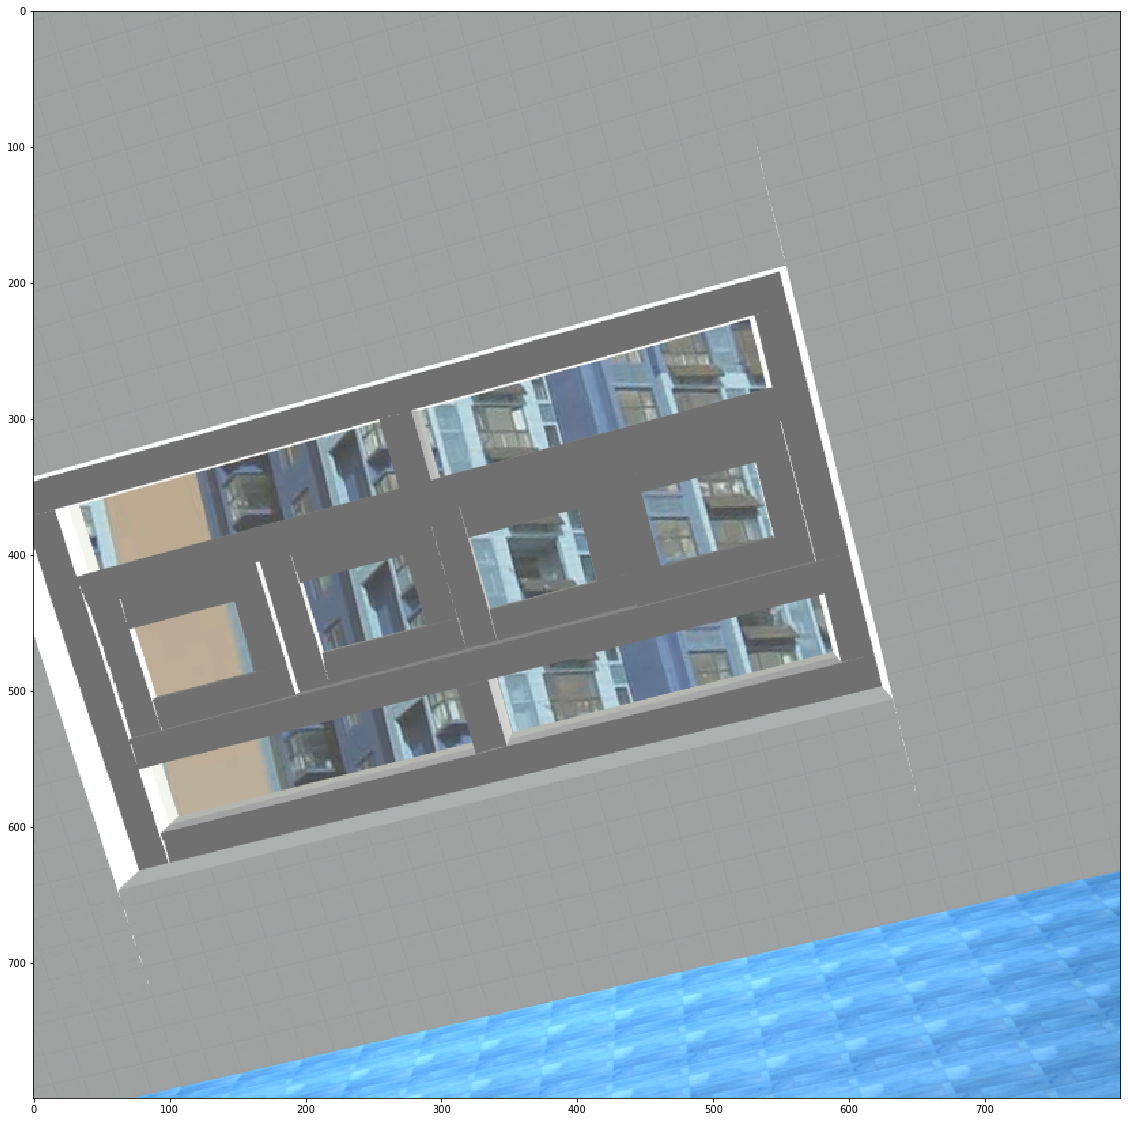

In [43]:
fig = plt.figure(figsize=(20, 20))
test_img = cv2.imread("./test.png")
plt.imshow(test_img)
plt.show()

In [14]:
test_img = cv2.resize(test_img, (2048, 1024))

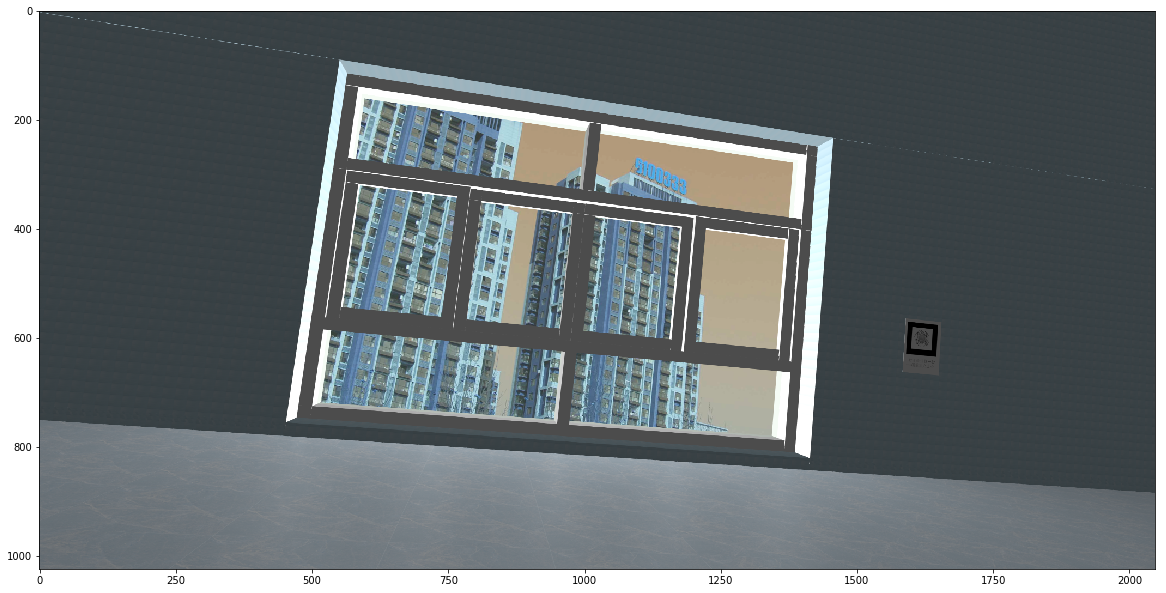

In [15]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(test_img)
plt.show()

In [44]:
# test_img = test_img.reshape((1, 1024, 2048, 3))
test_img = test_img.reshape((1, 800, 800, 3))
result = model.predict(test_img)

In [35]:
result[0].shape

(1, 800, 800, 1)

In [18]:
o1 = result[0].reshape((1024, 2048))
o2 = result[1].reshape((1024, 2048))
o3 = result[2].reshape((1024, 2048))
o4 = result[3].reshape((1024, 2048))
o5 = result[4].reshape((1024, 2048))
ofuse = result[5].reshape((1024, 2048))

In [45]:
o1 = result[0].reshape((800, 800))
o2 = result[1].reshape((800, 800))
o3 = result[2].reshape((800, 800))
o4 = result[3].reshape((800, 800))
o5 = result[4].reshape((800, 800))
ofuse = result[5].reshape((800, 800))

In [11]:
# result = result.reshape((800, 800))

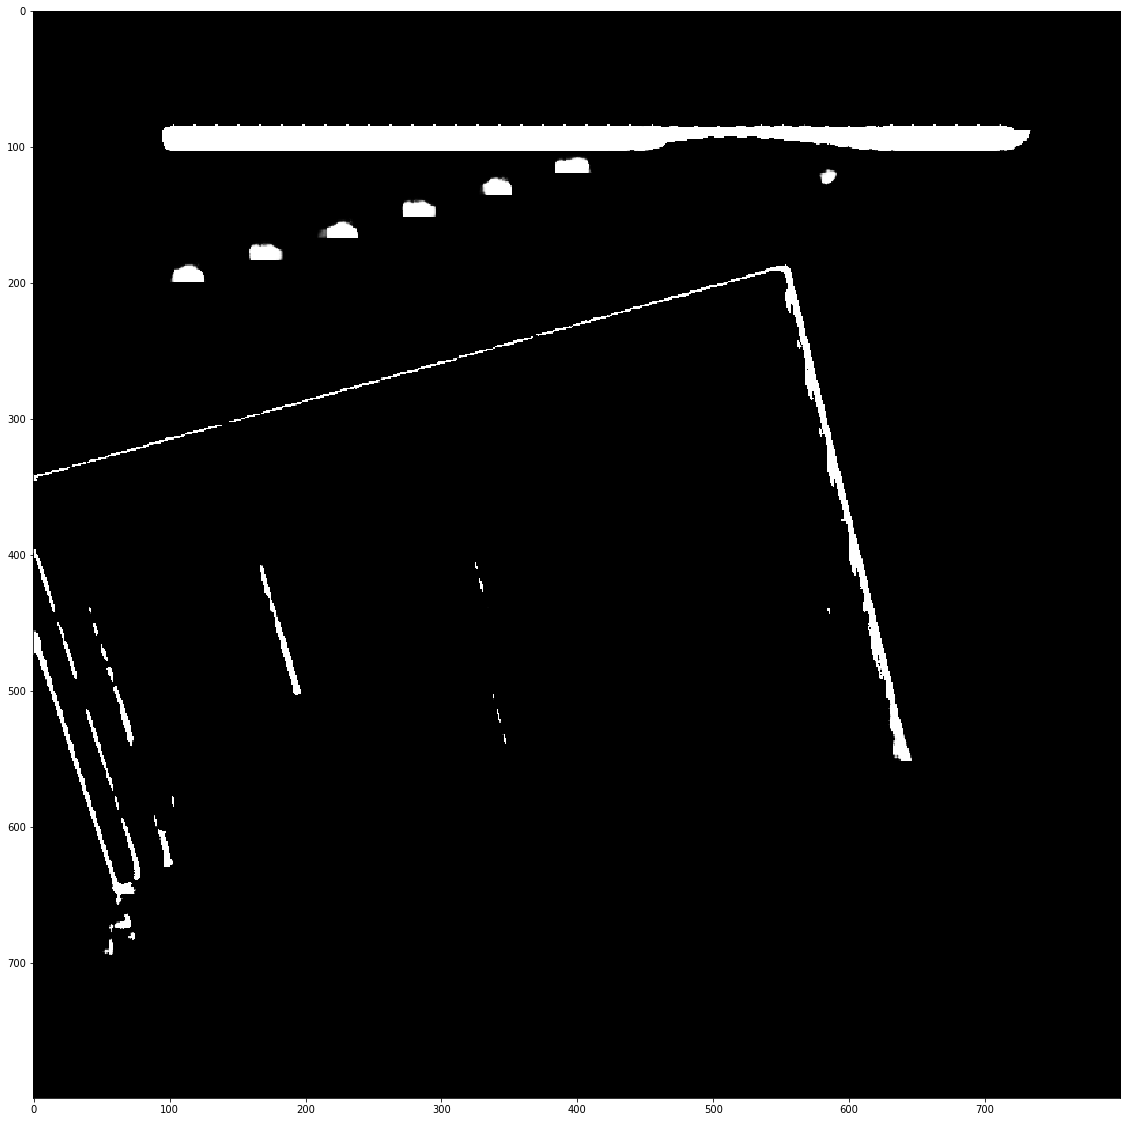

In [47]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(ofuse,cmap='gray')
plt.show()

In [36]:
result.shape

(800, 800)

In [19]:
fig = plt.figure(figsize=(20, 20))
label_img = labels_train[2]
label_img = label_img.reshape((800, 800))
plt.imshow(label_img, cmap='gray')
plt.show()

NameError: name 'labels_train' is not defined

<Figure size 1440x1440 with 0 Axes>